<a href="https://colab.research.google.com/github/poornass/Awesome-Vision-Attentions/blob/main/Copy_of_sasaresnet50_rp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import tarfile
import torchvision
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset, Dataset
import torch.optim as optim

from sklearn.metrics import precision_recall_fscore_support


In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
transform = transforms.Compose([

    # transforms.Resize((150,150)), #becasue vgg takes 150*150
    # transforms.Resize((32, 32)),
    transforms.Resize((224, 224)),

    # transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))

])


total_ds = ImageFolder('/content/drive/MyDrive/ChiSquareX/cnn_rp/cropped', transform=transform)


TEST_SIZE = 0.2
BATCH_SIZE = 2
SEED = 42
# SEED = 2021

# generate indices: instead of the actual data we pass in integers instead
train_indices, test_indices, _, _ = train_test_split(
    range(len(total_ds)),
    total_ds.targets,
    # stratify=total_ds.targets,
    test_size=TEST_SIZE,
    random_state=SEED
)

pred_indices, test_indices, _, _ = train_test_split(
    test_indices,
    range(len(test_indices)),
    # stratify=total_ds.targets,
    test_size=0.5,
    random_state=SEED
)

# generate subset based on indices
train_ds = Subset(total_ds, train_indices)
val_ds = Subset(total_ds, test_indices)
pred_ds = Subset(total_ds, pred_indices)

batch_size=4
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
pred_loader = DataLoader(pred_ds, batch_size, num_workers=2, pin_memory=True)

In [ ]:
import torch.nn.init as init

import math


class AttentionConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, groups=1, bias=False):
        super(AttentionConv, self).__init__()
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.groups = groups

        assert self.out_channels % self.groups == 0, "out_channels should be divided by groups. (example: out_channels: 40, groups: 4)"

        self.rel_h = nn.Parameter(torch.randn(out_channels // 2, 1, 1, kernel_size, 1), requires_grad=True)
        self.rel_w = nn.Parameter(torch.randn(out_channels // 2, 1, 1, 1, kernel_size), requires_grad=True)

        self.key_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)
        self.query_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)
        self.value_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)

        self.reset_parameters()

    def forward(self, x):
        batch, channels, height, width = x.size()

        padded_x = F.pad(x, [self.padding, self.padding, self.padding, self.padding])
        q_out = self.query_conv(x)
        k_out = self.key_conv(padded_x)
        v_out = self.value_conv(padded_x)

        k_out = k_out.unfold(2, self.kernel_size, self.stride).unfold(3, self.kernel_size, self.stride)
        v_out = v_out.unfold(2, self.kernel_size, self.stride).unfold(3, self.kernel_size, self.stride)

        k_out_h, k_out_w = k_out.split(self.out_channels // 2, dim=1)
        k_out = torch.cat((k_out_h + self.rel_h, k_out_w + self.rel_w), dim=1)

        k_out = k_out.contiguous().view(batch, self.groups, self.out_channels // self.groups, height, width, -1)
        v_out = v_out.contiguous().view(batch, self.groups, self.out_channels // self.groups, height, width, -1)

        q_out = q_out.view(batch, self.groups, self.out_channels // self.groups, height, width, 1)

        out = q_out * k_out
        out = F.softmax(out, dim=-1)
        out = torch.einsum('bnchwk,bnchwk -> bnchw', out, v_out).view(batch, -1, height, width)

        return out

    def reset_parameters(self):
        init.kaiming_normal_(self.key_conv.weight, mode='fan_out', nonlinearity='relu')
        init.kaiming_normal_(self.value_conv.weight, mode='fan_out', nonlinearity='relu')
        init.kaiming_normal_(self.query_conv.weight, mode='fan_out', nonlinearity='relu')

        init.normal_(self.rel_h, 0, 1)
        init.normal_(self.rel_w, 0, 1)


class AttentionStem(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, groups=1, m=4, bias=False):
        super(AttentionStem, self).__init__()
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.groups = groups
        self.m = m

        assert self.out_channels % self.groups == 0, "out_channels should be divided by groups. (example: out_channels: 40, groups: 4)"

        self.emb_a = nn.Parameter(torch.randn(out_channels // groups, kernel_size), requires_grad=True)
        self.emb_b = nn.Parameter(torch.randn(out_channels // groups, kernel_size), requires_grad=True)
        self.emb_mix = nn.Parameter(torch.randn(m, out_channels // groups), requires_grad=True)

        self.key_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)
        self.query_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)
        self.value_conv = nn.ModuleList([nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias) for _ in range(m)])

        self.reset_parameters()

    def forward(self, x):
        batch, channels, height, width = x.size()

        padded_x = F.pad(x, [self.padding, self.padding, self.padding, self.padding])

        q_out = self.query_conv(x)
        k_out = self.key_conv(padded_x)
        v_out = torch.stack([self.value_conv[_](padded_x) for _ in range(self.m)], dim=0)

        k_out = k_out.unfold(2, self.kernel_size, self.stride).unfold(3, self.kernel_size, self.stride)
        v_out = v_out.unfold(3, self.kernel_size, self.stride).unfold(4, self.kernel_size, self.stride)

        k_out = k_out[:, :, :height, :width, :, :]
        v_out = v_out[:, :, :, :height, :width, :, :]

        emb_logit_a = torch.einsum('mc,ca->ma', self.emb_mix, self.emb_a)
        emb_logit_b = torch.einsum('mc,cb->mb', self.emb_mix, self.emb_b)
        emb = emb_logit_a.unsqueeze(2) + emb_logit_b.unsqueeze(1)
        emb = F.softmax(emb.view(self.m, -1), dim=0).view(self.m, 1, 1, 1, 1, self.kernel_size, self.kernel_size)

        v_out = emb * v_out

        k_out = k_out.contiguous().view(batch, self.groups, self.out_channels // self.groups, height, width, -1)
        v_out = v_out.contiguous().view(self.m, batch, self.groups, self.out_channels // self.groups, height, width, -1)
        v_out = torch.sum(v_out, dim=0).view(batch, self.groups, self.out_channels // self.groups, height, width, -1)

        q_out = q_out.view(batch, self.groups, self.out_channels // self.groups, height, width, 1)

        out = q_out * k_out
        out = F.softmax(out, dim=-1)
        out = torch.einsum('bnchwk,bnchwk->bnchw', out, v_out).view(batch, -1, height, width)

        return out

    def reset_parameters(self):
        init.kaiming_normal_(self.key_conv.weight, mode='fan_out', nonlinearity='relu')
        init.kaiming_normal_(self.query_conv.weight, mode='fan_out', nonlinearity='relu')
        for _ in self.value_conv:
            init.kaiming_normal_(_.weight, mode='fan_out', nonlinearity='relu')

        init.normal_(self.emb_a, 0, 1)
        init.normal_(self.emb_b, 0, 1)
        init.normal_(self.emb_mix, 0, 1)


# temp = torch.randn((2, 3, 32, 32))
# conv = AttentionConv(3, 16, kernel_size=3, padding=1)
# print(conv(temp).size())


In [ ]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, groups=1, base_width=64):
        super(Bottleneck, self).__init__()
        self.stride = stride
        width = int(out_channels * (base_width / 64.)) * groups

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, width, kernel_size=1, bias=False),
            nn.BatchNorm2d(width),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            AttentionConv(width, width, kernel_size=7, padding=3, groups=8),
            nn.BatchNorm2d(width),
            nn.ReLU(),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(width, self.expansion * out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(self.expansion * out_channels),
        )

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        if self.stride >= 2:
            out = F.avg_pool2d(out, (self.stride, self.stride))

        out += self.shortcut(x)
        out = F.relu(out)

        return out


class Model(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1000, stem=True):
        super(Model, self).__init__()
        self.in_places = 64

        if stem:
            self.init = nn.Sequential(
                # # CIFAR10
                # AttentionStem(in_channels=3, out_channels=64, kernel_size=4, stride=1, padding=2, groups=1),
                # nn.BatchNorm2d(64),
                # nn.ReLU(),

                # For ImageNet
                AttentionStem(in_channels=3, out_channels=64, kernel_size=4, stride=1, padding=2, groups=1),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.MaxPool2d(4, 4)
            )
        else:
            self.init = nn.Sequential(
                # # CIFAR10
                # nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
                # nn.BatchNorm2d(64),
                # nn.ReLU(),

                # For ImageNet
                nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            )

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.dense = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_places, planes, stride))
            self.in_places = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.init(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.dense(out)

        return out


def ResNet26(num_classes=7, stem=False):
    return Model(Bottleneck, [1, 2, 4, 1], num_classes=num_classes, stem=stem)


def ResNet38(num_classes=7, stem=False):
    return Model(Bottleneck, [2, 3, 5, 2], num_classes=num_classes, stem=stem)


def ResNet50(num_classes=7, stem=False):
    return Model(Bottleneck, [3, 4, 6, 3], num_classes=num_classes, stem=stem)


def get_model_parameters(model):
    total_parameters = 0
    for layer in list(model.parameters()):
        layer_parameter = 1
        for l in list(layer.size()):
            layer_parameter *= l
        total_parameters += layer_parameter
    return total_parameters


# temp = torch.randn((2, 3, 224, 224))
model = ResNet50(num_classes=7, stem=False)
device = get_default_device()
device
model = to_device(model, device)
print(get_model_parameters(model))


16003975


In [ ]:
# def accuracy(outputs, labels):
#     _, preds = torch.max(outputs, dim=1)
#     return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
import os
from tqdm import tqdm
import shutil

# from config import get_args, get_logger
# from model import ResNet50, ResNet38, ResNet26
# from preprocess import load_data


def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = 0.01 * (0.1 ** (epoch // 30))    ##############################################################################################
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


def train(model, train_loader, optimizer, criterion, epoch):
    model.train()

    # train_acc = 0.0

    step = 0
    for data, target in train_loader:
        # adjust_learning_rate(optimizer, epoch)
        # if args.cuda:
        data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        y_pred = output.data.max(1)[1]

        # acc = float(y_pred.eq(target.data).sum()) / len(data) * 100.
        # train_acc += acc
        # step += 1
        # if step % 100 == 0:
        #     print("[Epoch {0:4d}] Loss: {1:2.3f} ".format(epoch, loss.data), end='')
        #     # logger.info("[Epoch {0:4d}] Loss: {1:2.3f} Acc: {2:.3f}%".format(epoch, loss.data, acc))
        #     for param_group in optimizer.param_groups:
        #         print(",  Current learning rate is: {}".format(param_group['lr']))
        #         # logger.info("Current learning rate is: {}".format(param_group['lr']))
    print("[Epoch {0:4d}] Loss: {1:2.3f} ".format(epoch, loss.data), end='')
    return epoch, loss.data


def eval(model, test_loader):
    model.eval()
    correct = 0
    pred = []
    labels = []
    probs = []
    with torch.no_grad():
        for data, target in test_loader:

            data, target = data.cuda(), target.cuda()
            labels.append(target.data)

            output = model(data)
            prediction = output.data.max(1)[1]
            pred.append(prediction)
            prob = torch.softmax(output, dim=1).detach().cpu()

            # print(prob)
            probs.append(prob)
            correct += prediction.eq(target.data).sum()

    acc = 100. * float(correct) / len(test_loader.dataset)
    print('Acc: {0:.2f}'.format(acc))
    return acc, pred, labels, probs


def get_model_parameters(model):
    total_parameters = 0
    for layer in list(model.parameters()):
        layer_parameter = 1
        for l in list(layer.size()):
            layer_parameter *= l
        total_parameters += layer_parameter
    return total_parameters


def save_checkpoint(state, is_best, filename):
    file_path = os.path.join('./checkpoint', filename)
    torch.save(state, file_path)
    best_file_path = os.path.join('./checkpoint', 'best_' + filename)
    if is_best:
        print('best Model Saving ...')
        shutil.copyfile(file_path, best_file_path)


# if __name__ == '__main__':
#     args, logger = get_args()
#     main(args, logger)


In [ ]:
lr = 0.01
epochs = 3   #150 for final results
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr, momentum=0.9)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=args.weight_decay)

best_acc = 0
history = []
for epoch in range(epochs):
  e, loss = train(model, train_loader, optimizer, criterion, epoch)
  eval_acc, _, _, _ = eval(model, pred_loader)

  history.append({'e':e, 'loss':loss.data, 'acc':eval_acc})

  if eval_acc > best_acc:
    best_acc = eval_acc
    torch.save(model.state_dict(), '/sample_data')


  # is_best = eval_acc > best_acc
  # best_acc = max(eval_acc, best_acc)

  # if not os.path.isdir('checkpoint'):
  #     os.mkdir('checkpoint')
  # filename = 'model_' + str(args.dataset) + '_' + str(args.model_name) + '_' + str(args.stem) + '_ckpt.tar'
  # print('filename :: ', filename)

  # parameters = get_model_parameters(model)

  # if torch.cuda.device_count() > 1:
  #     save_checkpoint({
  #         'epoch': epoch,
  #         # 'arch': args.model_name,
  #         'state_dict': model.module.state_dict(),
  #         'best_acc': best_acc,
  #         'optimizer': optimizer.state_dict(),
  #         'parameters': parameters,
  #     }, is_best, filename)
  # else:
  #     save_checkpoint({
  #         'epoch': epoch,
  #         # 'arch': args.model_name,
  #         'state_dict': model.state_dict(),
  #         'best_acc': best_acc,
  #         'optimizer': optimizer.state_dict(),
  #         'parameters': parameters,
  #     }, is_best, filename)


[Epoch    0] Loss: 1.260 Acc: 15.09
[Epoch    1] Loss: 1.662 Acc: 11.32
[Epoch    2] Loss: 2.379 Acc: 32.08


## Results

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
train_loss = [history[i]['loss'].detach().cpu() for i in range(epochs)]

accu = [history[i]['acc'] for i in range(epochs)]

In [ ]:
train_loss[0].detach().cpu()

tensor(1.2597)

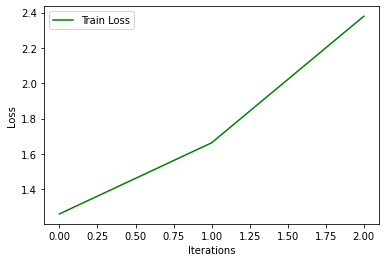

In [ ]:
iter = range(0, epochs)

plt.plot(iter, train_loss, 'g', label='Train Loss')
# plt.plot(iter, val_loss, 'r', label='Validation Loss')


plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

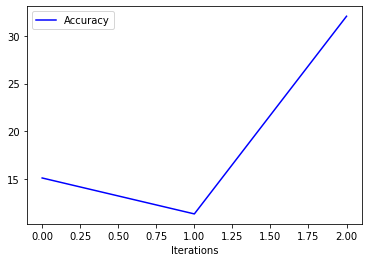

In [ ]:
plt.plot(iter, accu, 'b', label='Accuracy')

plt.xlabel('Iterations')
plt.legend()
plt.show()

In [ ]:
test_acc, pred, labels, probs = eval(model, test_loader)
# print(pred, labels)

Acc: 20.37


In [ ]:
saved_model = ResNet50(num_classes=7, stem=False)

saved_model.load_state_dict(torch.load('/sample_data'))
saved_model = to_device(saved_model, device)

In [ ]:
acc, pred, labels, probs =  eval(saved_model, test_loader)

Acc: 20.37


In [ ]:
l = [labels[i] for i in range(len(labels))]
lf = torch.cat(l)

p = [pred[i] for i in range(len(pred))]
pf = torch.cat(p)

prob_ = [probs[i] for i in range(len(probs))]
pred_prob = torch.cat(prob_).cpu().numpy()

In [ ]:
prfs = precision_recall_fscore_support(pf.cpu(), lf.cpu(), average='weighted')
print("Precision: {} \nRecall: {} \nF1 Score: {} ".format(prfs[0], prfs[1], prfs[2]))

Precision: 0.5940170940170941 
Recall: 0.2037037037037037 
F1 Score: 0.2986906098017209 


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


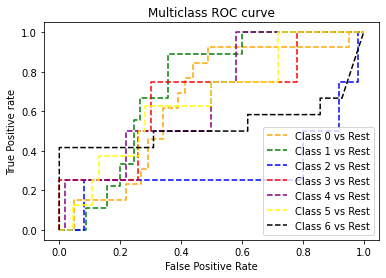

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score



# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 7

# pred_prob = pred['probs'][0].detach().cpu().numpy()
# a = pred_prob[pred['preds'][0].cpu().numpy() == 0]

# print(pred_prob, '\n --------------------------------------')
for i in range(n_class):
    # print( pred_prob[:,i])
    fpr[i], tpr[i], thresh[i] = roc_curve(lf.cpu(), pred_prob[:,i], pos_label=i)

# plotting
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='purple', label='Class 4 vs Rest')
plt.plot(fpr[5], tpr[5], linestyle='--',color='yellow', label='Class 5 vs Rest')
plt.plot(fpr[6], tpr[6], linestyle='--',color='black', label='Class 6 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
# plt.savefig('Multiclass ROC',dpi=300);
